In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

## Training Logistic Regression models on both Data with race and without race and comparing their scores to conclude correlations between race and factors like flee and armed 

In [122]:
# Load dataset
df = pd.read_csv('../datasets/police_shootings_cleaned.csv')

df.head()

,date,name,age,gender,armed,race,city,state,flee,body_camera,signs_of_mental_illness,police_departments_involved,age_group
0,2015-01-02,Lewis Lee Lembke,47.0,male,gun,White,Aloha,OR,not,False,False,"Washington County Sheriff's Office, OR",46-55
1,2015-01-02,Tim Elliot,53.0,male,gun,Asian,Shelton,WA,not,False,True,"Mason County Sheriff's Office, WA",46-55
2,2015-01-03,John Paul Quintero,23.0,male,unarmed,Hispanic,Wichita,KS,not,False,False,"Wichita Police Department, KS",19-25
3,2015-01-04,Kenneth Joe Brown,18.0,male,gun,White,Guthrie,OK,not,False,False,"Oklahoma Highway Patrol, OK",19-25
4,2015-01-04,Matthew Hoffman,32.0,male,replica,White,San Francisco,CA,not,False,True,"San Francisco Police Department, CA",26-35


In [123]:
# Preprocess the dataset
# Convert categorical variables to numerical format
df['flee'] = df['flee'].apply(lambda x: 1 if x.lower() != 'not' else 0)  # 1 = Flee, 0 = Not Fleeing
df['mental_illness'] = df['signs_of_mental_illness'].apply(lambda x: 1 if x else 0)  # 1 = Yes, 0 = No
df['body_camera'] = df['body_camera'].apply(lambda x: 1 if x else 0)  # 1 = Body Camera Present, 0 = Not Present


In [124]:
# primed unique values of 'armed' and count

df['armed'].value_counts()

# put blunt_objects into unarmed

df['armed'] = df['armed'].apply(lambda x: 'unarmed' if x == 'blunt_object' else x)

#drop those which are undetermined

df = df[df['armed'] != 'undetermined']

In [125]:
# Encode race as one-hot
df = pd.get_dummies(df, columns=['race'], drop_first=True)

#encode armed as one-hot
df = pd.get_dummies(df, columns=['armed'], drop_first=True)


# Drop irrelevant columns
df = df[['flee', 'age', 'mental_illness', 'body_camera'] + [col for col in df.columns if col.startswith('race_')] + [col for col in df.columns if col.startswith('armed_')]]

# Drop rows with missing values
df = df.dropna()

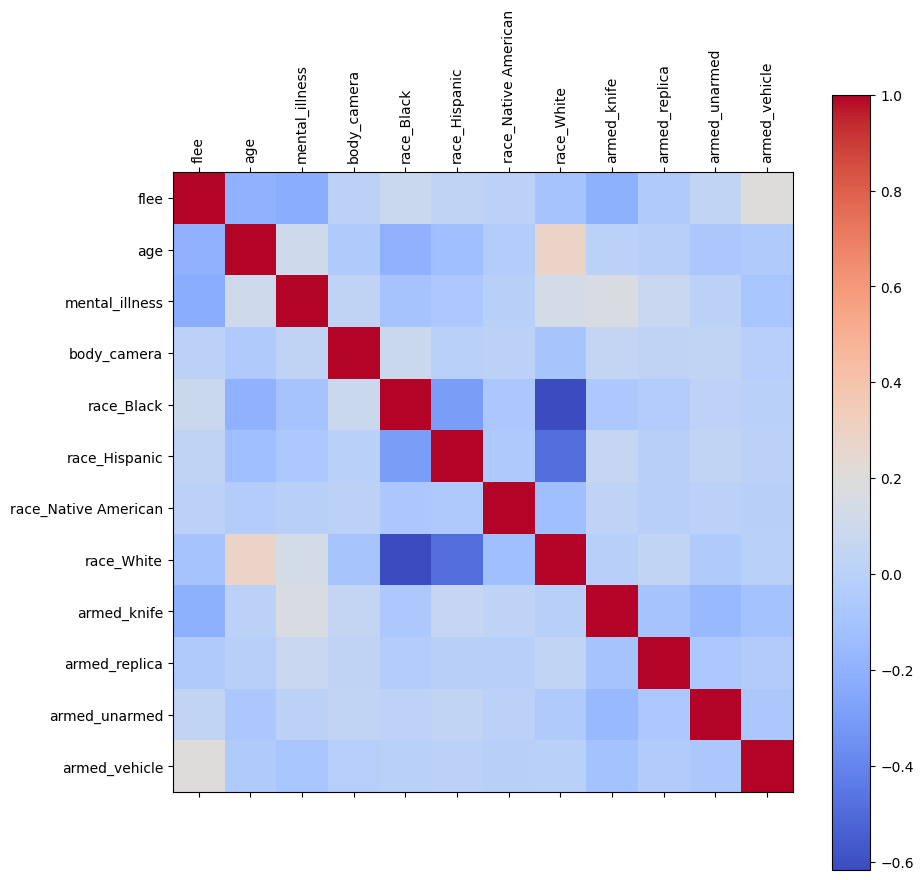

<Figure size 640x480 with 0 Axes>

In [126]:
# make a flee heatmap with race armed mental illness and body camera and age

plt.figure(figsize=(10, 10))
plt.matshow(df.corr(), cmap='coolwarm', fignum=1)
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.yticks(range(df.shape[1]), df.columns)
plt.colorbar()
plt.show()


if not os.path.exists('pred'):
    os.makedirs('pred')
plt.savefig('pred/heatmap_flee.png')



Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1317
           1       0.67      0.74      0.70      1316

    accuracy                           0.69      2633
   macro avg       0.69      0.69      0.68      2633
weighted avg       0.69      0.69      0.68      2633


ROC-AUC Score: 0.73


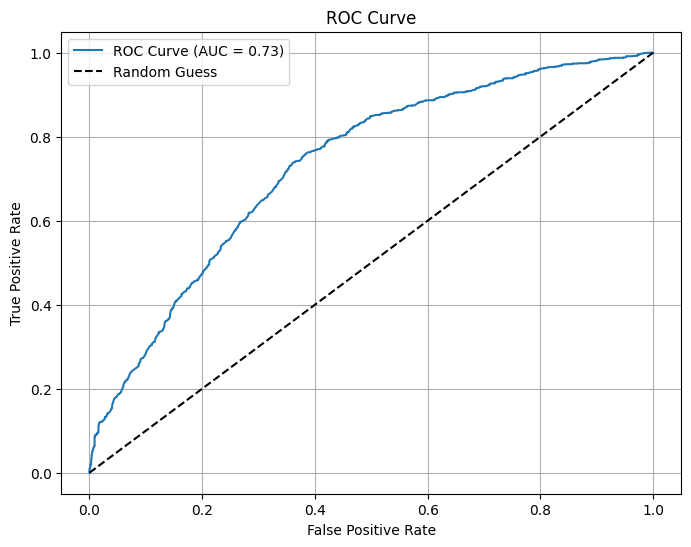

<Figure size 640x480 with 0 Axes>

In [127]:


# Split into features (X) and target (y)
X = df.drop('flee', axis=1)
y = df['flee']

# Normalize numerical features
scaler = StandardScaler()
X[['age']] = scaler.fit_transform(X[['age']])

# Oversample minority classes
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of fleeing
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

if(not os.path.exists('pred')):
    os.makedirs('pred')
plt.savefig('pred/roc_curve_flee1.png')


Index(['age', 'mental_illness', 'body_camera', 'armed_knife', 'armed_replica',
       'armed_unarmed', 'armed_vehicle'],
      dtype='object')
Accuracy: 0.68

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      1317
           1       0.66      0.75      0.70      1316

    accuracy                           0.68      2633
   macro avg       0.69      0.68      0.68      2633
weighted avg       0.69      0.68      0.68      2633


ROC-AUC Score: 0.73


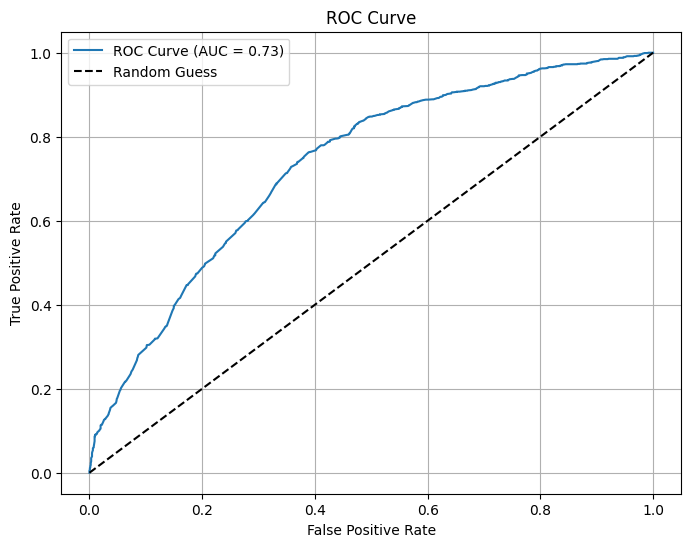

<Figure size 640x480 with 0 Axes>

In [128]:
# drop races
X = X.drop([col for col in X.columns if col.startswith('race_')], axis=1)
print(X.columns)

from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_resampled2, y_resampled2 = oversampler.fit_resample(X, y)

# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_resampled2, y_resampled2, test_size=0.3, random_state=42, stratify=y_resampled2)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)



# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of fleeing
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

#plot ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

if(not os.path.exists('pred')):
    os.makedirs('pred')
plt.savefig('pred/roc_curve_flee2.png')



In [129]:
# df.drop([col for col in df.columns if col.startswith('race_')])


df.drop([col for col in df.columns if col.startswith('race_')], axis=1, inplace=True)
print(df.corr()['flee'])


flee              1.000000
age              -0.200075
mental_illness   -0.221427
body_camera       0.013820
armed_knife      -0.205340
armed_replica    -0.049781
armed_unarmed     0.035453
armed_vehicle     0.197600
Name: flee, dtype: float64


In [130]:

df2 = pd.read_csv('../datasets/police_shootings_cleaned.csv')

df2['flee'] = df2['flee'].apply(lambda x: 1 if x.lower() != 'not' else 0)  # 1 = Flee, 0 = Not Fleeing
df2['mental_illness'] = df2['signs_of_mental_illness'].apply(lambda x: 1 if x else 0)  # 1 = Yes, 0 = No
df2['body_camera'] = df2['body_camera'].apply(lambda x: 1 if x else 0)  # 1 = Body Camera Present, 0 = Not Present
#drop those which are undetermined and include blunt_objects into unarmed and 0 1 armed unaremd

df2 = df2[df2['armed'] != 'undetermined']
# if unarmed / blunt_object then 0 else 1

df2['armed'] = df2['armed'].apply(lambda x: 0 if x == 'unarmed' or x == 'blunt_object' else 1)

# Encode race as one-hot
df2 = pd.get_dummies(df2, columns=['race'], drop_first=True)

df2 = df2[['flee', 'age', 'armed', 'mental_illness', 'body_camera'] + [col for col in df2.columns if col.startswith('race_')] + [col for col in df2.columns if col.startswith('armed_')]]

print(df2.head())



   flee   age  armed  mental_illness  body_camera  race_Black  race_Hispanic  \
0     0  47.0      1               0            0       False          False   
1     0  53.0      1               1            0       False          False   
2     0  23.0      0               0            0       False           True   
3     0  18.0      1               0            0       False          False   
4     0  32.0      1               1            0       False          False   

   race_Native American  race_White  
0                 False        True  
1                 False       False  
2                 False       False  
3                 False        True  
4                 False        True  


Index(['flee', 'age', 'mental_illness', 'body_camera', 'race_Black',
       'race_Hispanic', 'race_Native American', 'race_White'],
      dtype='object')
Accuracy: 0.56

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1855
           1       0.56      0.56      0.56      1854

    accuracy                           0.56      3709
   macro avg       0.56      0.56      0.56      3709
weighted avg       0.56      0.56      0.56      3709


ROC-AUC Score: 0.59


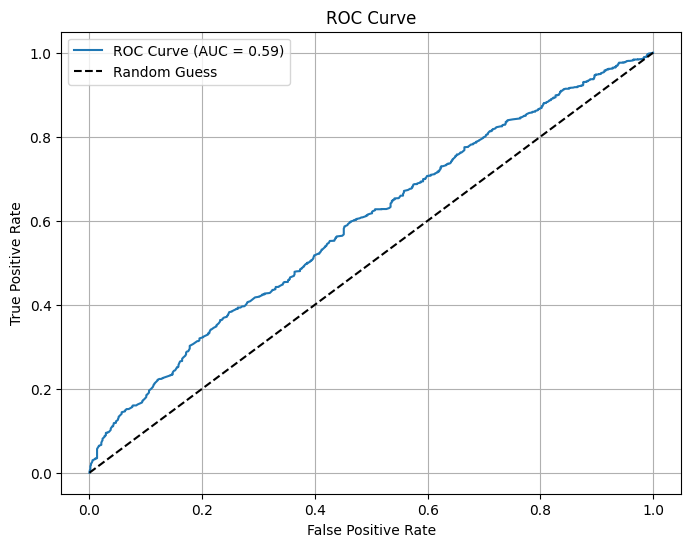

<Figure size 640x480 with 0 Axes>

In [131]:

X = df2.drop('armed', axis=1)
y = df2['armed']
print(X.columns)

# Normalize numerical features
scaler = StandardScaler()
X[['age']] = scaler.fit_transform(X[['age']])
# Split into train and test setsfrom imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of fleeing
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

if(not os.path.exists('pred')):
    os.makedirs('pred')
plt.savefig('pred/roc_curve_armed1.png')

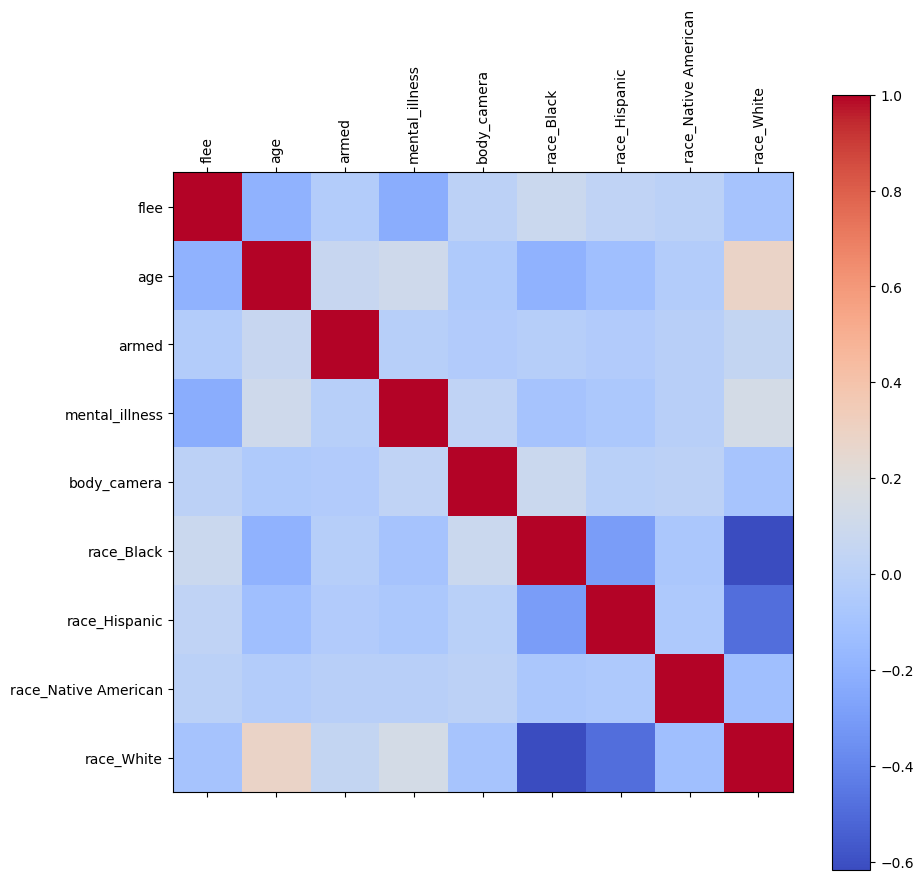

<Figure size 640x480 with 0 Axes>

In [132]:
# plot heat map between armed and other features
plt.figure(figsize=(10, 10))
plt.matshow(df2.corr(), cmap='coolwarm', fignum=1)
plt.xticks(range(df2.shape[1]), df2.columns, rotation=90)
plt.yticks(range(df2.shape[1]), df2.columns)
plt.colorbar()
plt.show()

if(not os.path.exists('pred')):
    os.makedirs('pred')
plt.savefig('pred/heatmap_armed.png')

Index(['flee', 'age', 'mental_illness', 'body_camera'], dtype='object')
Accuracy: 0.55

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1855
           1       0.55      0.54      0.55      1854

    accuracy                           0.55      3709
   macro avg       0.55      0.55      0.55      3709
weighted avg       0.55      0.55      0.55      3709


ROC-AUC Score: 0.58


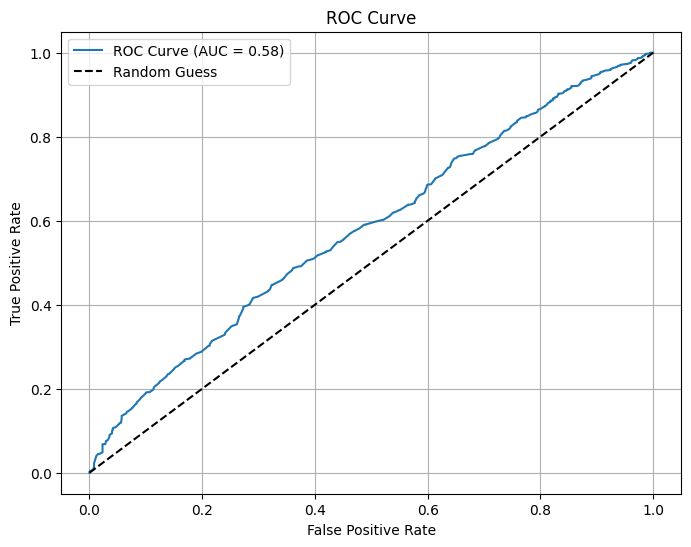

<Figure size 640x480 with 0 Axes>

In [133]:
X = df2.drop('armed', axis=1)
X = X.drop([col for col in X.columns if col.startswith('race')], axis=1)
y = df2['armed']
print(X.columns)


# Normalize numerical features
scaler = StandardScaler()
X[['age']] = scaler.fit_transform(X[['age']])

from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of fleeing
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

if(not os.path.exists('pred')):
    os.makedirs('pred')
plt.savefig('pred/roc_curve_armed2.png')